# User Interface for robot simulation

 ## This is the second assignment of Research Track 2

 Import necessary modules

In [1]:
import rospy
import actionlib
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import numpy as np
from assignment_2_2023.msg import pos, PlanningAction, PlanningGoal
from geometry_msgs.msg import Point
from nav_msgs.msg import Odometry
from std_srvs.srv import Empty
from ipywidgets import interact, widgets
from IPython.display import display
from actionlib_msgs.msg import GoalStatus

%matplotlib widget

Class for visualization

In [2]:
class Visualiser:
    def __init__(self):
        # Initialize figure with two subplots
        self.fig, (self.ax1, self.ax2) = plt.subplots(1, 2)
        # Initialize for plotting robot position
        self.robot_ln, = self.ax1.plot([], [], 'ro', label='Robot')
        self.current_target_ln, = self.ax1.plot([], [], 'bx', label='Current Target')
        self.reached_targets_ln, = self.ax1.plot([], [], 'gx', label='Reached Targets')
        # Data for robot position and target position
        self.x_data, self.y_data = [], []
        self.target_x, self.target_y = None, None
        self.reached_targets_positions =[]

        # Initialize for plotting target status
        self.reached_targets = 0
        self.unreached_targets = 0
        bars = self.ax2.bar(['Reached', 'Not Reached'], [self.reached_targets, self.unreached_targets])
        self.reached_bar = bars[0]
        self.unreached_bar = bars[1]
        
    def plot_init(self):
        # Initialize for plotting robot position
        self.ax1.set_title('Robot Position and Target')
        self.ax1.set_xlabel('X')
        self.ax1.set_ylabel('Y')
        self.ax1.set_xlim(-10, 10)
        self.ax1.set_ylim(-10, 10)
        self.ax1.legend()
        # Initialize for plotting target status
        self.ax2.set_title('Targets Status')
        self.ax2.set_ylim(0, 10)

    def show(self):
        plt.show()

Class for action client

In [3]:
class ActionClient:
    def __init__(self, visualiser):
        # Initialize ROS node
        rospy.init_node('ActionClient', anonymous=True)
        # Assign the visualiser
        self.visualiser = visualiser

        # Create publishers and subscribers
        self.pos_pub = rospy.Publisher('/robot_pos', pos, queue_size=1)
        self.target_pub = rospy.Publisher('/target_coordinates', Point, queue_size=1)
        rospy.Subscriber('/odom', Odometry, self.odom_callback)
        
        # Action client for goal setting
        self.action_client = actionlib.SimpleActionClient('/reaching_goal', PlanningAction)
        self.action_client.wait_for_server()

        self.goal = PlanningGoal()

    def odom_callback(self, data):
        # Extract position
        position = data.pose.pose.position
        linear_velocity = data.twist.twist.linear
        
        # Update position data
        pos_msg = pos()
        pos_msg.x = position.x
        pos_msg.y = position.y
        pos_msg.vx = linear_velocity.x
        pos_msg.vy = linear_velocity.y

        self.pos_pub.publish(pos_msg)
        self.visualiser.x_data.append(position.x)
        self.visualiser.y_data.append(position.y)

        
    def reached_callback(self,state,reslt):
        if state == GoalStatus.SUCCEEDED:
             #increment the counter for reached goals
            self.visualiser.reached_targets += 1
            self.visualiser.unreached_targets -= 1
            rospy.loginfo("Goal reached!")
            self.visualiser.reached_targets_positions.append((self.visualiser.target_x, self.visualiser.target_y))
            self.visualiser.target_x, self.visualiser.target_y = None, None
    
    def set_goal(self, x, y):
        self.goal.target_pose.pose.position.x = x
        self.goal.target_pose.pose.position.y = y
        self.action_client.send_goal(self.goal, done_cb=self.reached_callback)
        
        target_msg = Point()
        target_msg.x = x
        target_msg.y = y
        self.target_pub.publish(target_msg)
        
        self.visualiser.target_x = x
        self.visualiser.target_y = y
        self.visualiser.unreached_targets += 1

    def cancel_goal(self):
        self.action_client.cancel_goal()
        rospy.loginfo("Goal cancelled")
        self.visualiser.target_x = None
        self.visualiser.target_y = None
        self.visualiser.unreached_targets -= 1
        

## User Interface
Set the goal coordinates and click "Set Goal" button.

To cancel the goal, click "Cancel Goal" button.

Here, there are two plots:
- The left one displays the robot's motion and the target position.

- The right one shows the status of the goals.



FloatText(value=0.0, description='X:')

FloatText(value=0.0, description='Y:')

Button(description='Set Goal', style=ButtonStyle())

Button(description='Cancel Goal', style=ButtonStyle())

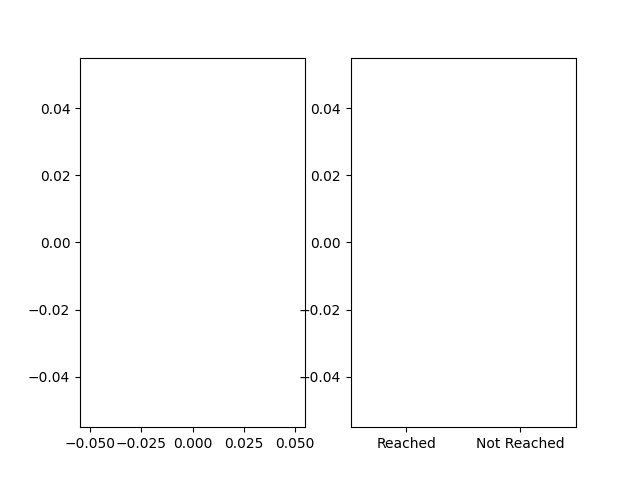

In [4]:
# Initialize the Visualiser
visualiser = Visualiser()

# Initialize the ActionClient with the visualiser
client = ActionClient(visualiser)


def update_robot_plot(frame):
    visualiser.robot_ln.set_data(visualiser.x_data, visualiser.y_data)
    if visualiser.target_x is not None and visualiser.target_y is not None:
        visualiser.current_target_ln.set_data([visualiser.target_x], [visualiser.target_y])
    else:
        visualiser.current_target_ln.set_data([], [])
    
    if visualiser.reached_targets_positions:
        x_reached, y_reached = zip(*visualiser.reached_targets_positions)
        visualiser.reached_targets_ln.set_data(x_reached, y_reached)
    else:
        visualiser.reached_targets_ln.set_data([], [])
    
    return visualiser.robot_ln, visualiser.current_target_ln, visualiser.reached_targets_ln



def update_status_plot(frame):
    visualiser.reached_bar.set_height(visualiser.reached_targets)
    visualiser.unreached_bar.set_height(visualiser.unreached_targets)
    return visualiser.reached_bar, visualiser.unreached_bar
    
  


# Create interactive widgets for user input
x_widget = widgets.FloatText(description='X:')
y_widget = widgets.FloatText(description='Y:')
goal_button = widgets.Button(description='Set Goal')
cancel_button = widgets.Button(description='Cancel Goal')

def set_goal_action(button):
    client.set_goal(x_widget.value, y_widget.value)

def cancel_goal_action(button):
    client.cancel_goal()

goal_button.on_click(set_goal_action)
cancel_button.on_click(cancel_goal_action)

display(x_widget, y_widget, goal_button, cancel_button)

# ani = FuncAnimation(visualiser.fig, update_robot_plot,init_func=visualiser.plot_init, blit=True)
ani = FuncAnimation(visualiser.fig, update_robot_plot, init_func=visualiser.plot_init, frames=np.arange(0, 10, 1), blit=True, cache_frame_data=False)
ani2 = FuncAnimation(visualiser.fig, update_status_plot, frames=np.arange(0, 10, 1), blit=False, cache_frame_data=False)

# Show plots
visualiser.show()